In [9]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
import os
os.listdir('/kaggle/input/detect-emotions-of-your-favorite-toons/')

['frames', '96714c94-6-Dataset']

In [11]:
def random_seed(seed_value):
    import random 
    random.seed(seed_value) # Python
    import numpy as np
    np.random.seed(seed_value) # cpu vars
    import torch
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [12]:
train_df = pd.read_csv('/kaggle/input/detect-emotions-of-your-favorite-toons/96714c94-6-Dataset/Dataset/Train.csv')
test_df = pd.read_csv('/kaggle/input/detect-emotions-of-your-favorite-toons/96714c94-6-Dataset/Dataset/Test.csv')

In [13]:
train_df.head(3)

,Frame_ID,Emotion
0,frame0.jpg,happy
1,frame1.jpg,happy
2,frame2.jpg,surprised


In [14]:
test_df.head(2)


,Frame_ID
0,test0.jpg
1,test1.jpg


In [15]:

data_folder = Path('/kaggle/input/detect-emotions-of-your-favorite-toons/frames/')

In [17]:
random_seed(42)

test_img = ImageList.from_df(test_df, path=data_folder, folder='test_frames')

trfm = get_transforms()

train_img = (ImageList.from_df(train_df, path=data_folder, folder='train_frames')
        .split_by_rand_pct(0.1)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=224)
        .databunch(path='.', bs=32, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

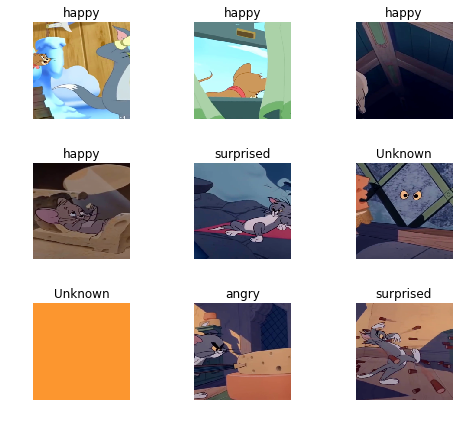

In [18]:
train_img.show_batch(rows=3, figsize=(7,6))

In [49]:

## print the target classes
print(train_img.classes)

['Unknown', 'angry', 'happy', 'sad', 'surprised']


In [19]:

print(train_img.classes)
len(train_img.classes), train_img.c

['Unknown', 'angry', 'happy', 'sad', 'surprised']


(5, 5)

In [20]:
random_seed(42)
learn = cnn_learner(train_img, models.resnet101, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [21]:
random_seed(42)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.112961,3.333913,0.551724,0.448276,00:13
1,1.580413,2.465043,0.379310,0.620690,00:12
2,1.317063,1.520020,0.310345,0.689655,00:11
3,1.126645,2.107359,0.344828,0.655172,00:12
4,0.981854,2.047336,0.310345,0.689655,00:12
5,0.871111,1.896640,0.344828,0.655172,00:12
6,0.766858,1.769011,0.344828,0.655172,00:11
7,0.682393,1.673658,0.344828,0.655172,00:11
8,0.616045,1.551792,0.344828,0.655172,00:13
9,0.576389,1.527776,0.344828,0.655172,00:12


In [22]:

learn.save('stage-1')

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(train_img.valid_ds)==len(losses)==len(idxs)

True

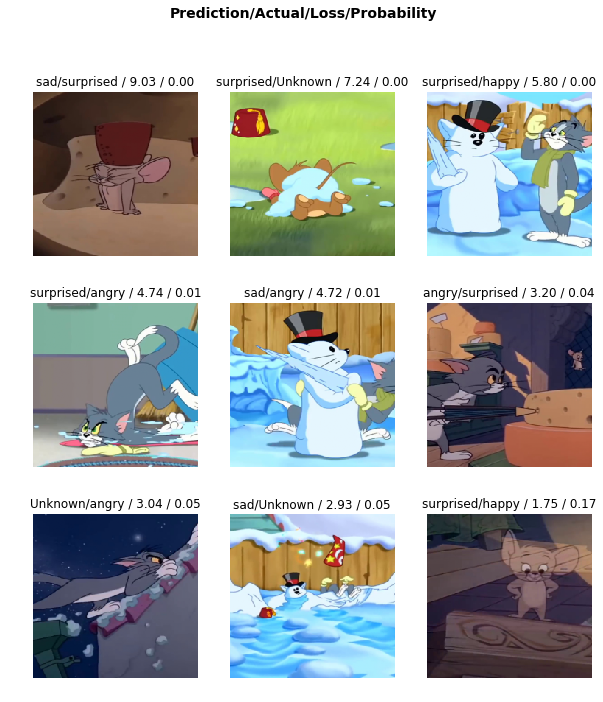

In [24]:
interp.plot_top_losses(9, figsize=(10,11))

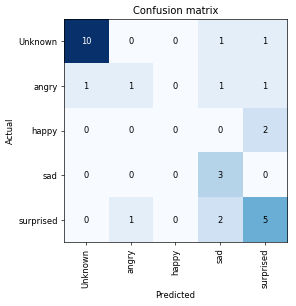

In [25]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [30]:

interp.most_confused(min_val=2)

[('happy', 'surprised', 2), ('surprised', 'sad', 2)]

In [31]:
learn.unfreeze()

In [32]:
random_seed(42)
learn.freeze_to(-3)
learn.fit_one_cycle(5, wd=0.5)
learn.save('stage-2');

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.039943,1.654916,0.310345,0.689655,00:12
1,0.206302,3.959958,0.379310,0.620690,00:13
2,0.464549,4.746459,0.379310,0.620690,00:12
3,0.538603,2.364548,0.344828,0.655172,00:12
4,0.533535,1.811402,0.344828,0.655172,00:12


In [33]:
random_seed(42)
learn.freeze_to(-2)
learn.fit_one_cycle(5, wd=0.5)
learn.save('stage-3');

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.380221,1.832977,0.310345,0.689655,00:12
1,0.331964,2.024687,0.310345,0.689655,00:12
2,0.297767,1.692636,0.310345,0.689655,00:15
3,0.325790,1.721230,0.344828,0.655172,01:04
4,0.329653,1.573919,0.310345,0.689655,00:13


In [34]:
random_seed(42)
learn.freeze_to(-1)
learn.fit_one_cycle(5, wd=0.4)
learn.save('stage-4');

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.122096,1.514473,0.310345,0.689655,00:13
1,0.087004,1.512480,0.310345,0.689655,00:11
2,0.063187,1.428454,0.241379,0.758621,00:11
3,0.056058,1.641864,0.206897,0.793103,00:11
4,0.090033,1.714323,0.241379,0.758621,00:12


In [35]:

import numpy as np
import pandas as pd

In [36]:
learn.load('stage-4')
log_preds, test_labels = learn.get_preds(ds_type=DatasetType.Test)

In [43]:
log_preds

tensor([[4.9432e-07, 5.5253e-02, 9.8580e-05, 6.9307e-06, 9.4464e-01],
        [3.2576e-07, 3.8307e-01, 1.3679e-04, 1.3227e-04, 6.1666e-01],
        [8.7546e-04, 9.8319e-04, 9.8394e-01, 1.3205e-02, 9.9365e-04],
        [1.4875e-05, 1.4685e-04, 9.9953e-01, 1.2564e-05, 2.9802e-04],
        [2.8700e-05, 5.2467e-01, 7.2262e-03, 3.9211e-03, 4.6416e-01],
        [5.1202e-04, 3.8282e-01, 1.5091e-02, 9.9677e-04, 6.0058e-01],
        [9.1828e-01, 1.0872e-02, 4.4063e-02, 2.4224e-02, 2.5572e-03],
        [2.4960e-04, 1.2168e-03, 7.0766e-01, 1.8711e-02, 2.7216e-01],
        [9.8385e-06, 5.5520e-01, 4.0498e-03, 3.3141e-02, 4.0760e-01],
        [7.6871e-06, 2.6137e-01, 2.8115e-03, 1.8112e-02, 7.1770e-01],
        [1.9865e-05, 5.5134e-01, 1.5315e-01, 1.3076e-01, 1.6473e-01],
        [3.9093e-05, 4.9786e-01, 1.6743e-01, 1.5645e-01, 1.7822e-01],
        [7.2482e-05, 7.0490e-01, 2.8261e-02, 1.1047e-02, 2.5572e-01],
        [2.9226e-05, 2.7352e-01, 2.0605e-02, 1.1777e-03, 7.0467e-01],
        [1.9700e-09,

In [53]:
preds = np.argmax(log_preds, 1)

In [54]:
preds

tensor([4, 4, 2, 2, 1, 4, 0, 2, 1, 4, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4,
        4, 0, 1, 4, 0, 4, 4, 4, 4, 4, 4, 3, 4, 1, 1, 4, 4, 3, 4, 4, 4, 2, 2, 2,
        0, 4, 2, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 4, 4, 2, 4, 4, 0, 4, 4, 1, 0,
        4, 2, 4, 1, 2, 2, 2, 0, 2, 2, 1, 4, 4, 4, 1, 4, 4, 4, 4, 1, 1, 4, 2, 2,
        4, 4, 4, 1, 2, 0, 0, 0, 2, 2, 4, 2, 2, 2, 2, 4, 4, 4, 4, 4, 2, 4, 2, 2,
        4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 2, 2, 0, 4, 0, 4, 2, 4, 2, 2, 4, 4, 2, 2,
        0, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 2, 2, 1, 1, 1, 4, 4, 1, 4, 2, 1, 4,
        4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 0, 0, 0, 0, 4, 2, 4])

In [47]:
test_df['Emotion'] = preds
test_df.head(3)

,Frame_ID,Emotion
0,test0.jpg,4
1,test1.jpg,4
2,test2.jpg,2


In [48]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(test_df)